In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_112_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_086_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_043_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_063_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_273_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_094_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_135_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_056_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_055_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_396_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_302_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/img_110_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_176_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_131_05_0.png
/kaggle/input/blurredimages/BlurryVision/BlURRY/timg_362_05_0.png
/kaggle/input/blur

In [2]:
import os
path='/kaggle/input/blurredimages/BlurryVision'
os.listdir(path)

['BlURRY', 'GT']

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm
from skimage.metrics import structural_similarity as ssim

In [4]:
# Define image size
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = IMAGE_SIZE + [3]

In [5]:
# File paths
train_filepath_blur = '/kaggle/input/blurredimages/BlurryVision/BlURRY'
train_filepath_clean='/kaggle/input/blurredimages/BlurryVision/GT'
#val_filepath_blur = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

In [6]:
from PIL import Image
import numpy as np
train_images_blur=[]
train_images_clean=[]

for train_file_blur in tqdm(os.listdir(train_filepath_blur), desc="Building blurring Dataset:"):
    img_path = os.path.join(train_filepath_blur, train_file_blur)
    img = np.array(Image.open(img_path))
    train_images_blur.append(img)

for train_file_clean in tqdm(os.listdir(train_filepath_clean), desc="Building clean dataset:"):
    img_path = os.path.join(train_filepath_clean, train_file_clean)
    img = np.array(Image.open(img_path))
    train_images_clean.append(img)






Building blurring Dataset::   0%|          | 0/700 [00:00<?, ?it/s]

Building clean dataset::   0%|          | 0/700 [00:00<?, ?it/s]

In [7]:
from sklearn.model_selection import train_test_split

assert len(train_images_blur)==len(train_images_clean),"mismastch in number of blurred or clean images."

# CORRECT:
train_blur, test_blur, train_clean, test_clean = train_test_split(
    train_images_blur, train_images_clean,
    test_size=0.2,
    random_state=42
)
print(f"training set size:{len(train_blur)}")
print(f"testing set size:{len(test_blur)}")

training set size:560
testing set size:140


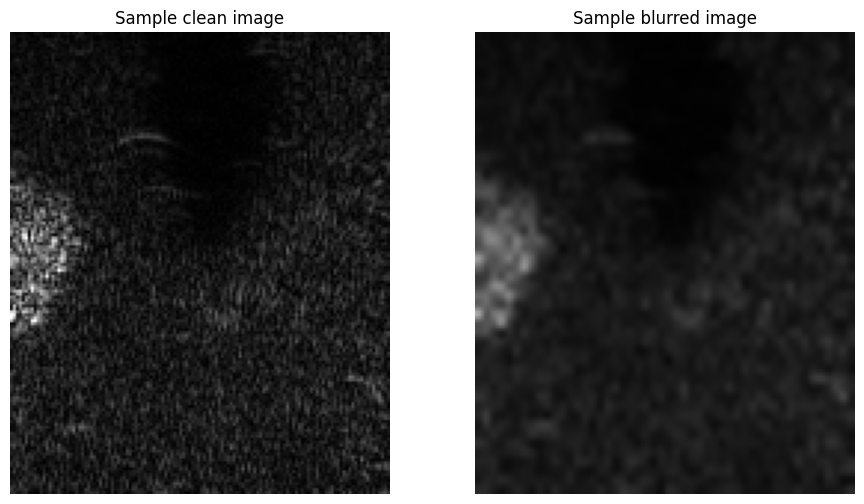

In [8]:
# Visualize samples
plt.figure(figsize=[11, 6])
for i in range(1):
    img = train_images_clean[i]
    blur_img = train_images_blur[i]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample clean image')

    plt.subplot(1, 2, 2)
    plt.imshow(blur_img)
    plt.axis('off')
    plt.title('Sample blurred image')
plt.show()


In [9]:
# Convert lists to numpy arrays
train_images_blur = np.stack(train_blur).astype("float32")
train_images_clean = np.stack(train_clean).astype("float32")

In [10]:

class DoubleConvBlur(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlur, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        

    def forward(self, x):
        return self.conv(x)


class Deblurring(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512,1024]):
        super(Deblurring, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling part
        for feature in features:
            self.downs.append(DoubleConvBlur(in_channels, feature))
            in_channels = feature

        # Upsampling part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConvBlur(feature * 2, feature))

        # Bottleneck and final layer
        self.bottleneck = DoubleConvBlur(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [11]:
from torch.utils.data import Dataset
import torch

class CustomTrainData(Dataset):
    def __init__(self, blur_images, clean_images, transform=None):
        self.blur_images = blur_images
        self.clean_images = clean_images
        self.transform = transform
        print(f"Total valid images: {len(self.blur_images)}")

    def __len__(self):
        return len(self.blur_images)

    def __getitem__(self, idx):
        clean_image = self.clean_images[idx]
        blurred_image = self.blur_images[idx]

        clean_image = torch.tensor(clean_image).permute(2, 0, 1).float()
        blurred_image = torch.tensor(blurred_image).permute(2, 0, 1).float()

        if self.transform:
            clean_image = self.transform(clean_image)
            blurred_image = self.transform(blurred_image)

        return blurred_image, clean_image


In [12]:
from torch.utils.data import DataLoader
train_dataset = CustomTrainData(train_images_blur, train_images_clean)
#val_dataset = CustomTrainDataset(val_images, val_masks_enc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
for blurred_image,clean_image in train_loader:
  print("Train batch-Clean images shape:",blurred_image.shape)
  print("Train batch-Mask shape:",clean_image.shape)
  break

Total valid images: 560
Train batch-Clean images shape: torch.Size([8, 3, 156, 128])
Train batch-Mask shape: torch.Size([8, 3, 156, 128])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Deblurring(in_channels=3, out_channels=3).to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 70

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for blurred_img, clean_img in train_loader_tqdm:
        clean_img = clean_img.to(device)
        blurred_img = blurred_img.to(device)

        optimizer.zero_grad()
        output = model(blurred_img)
        loss = loss_fn(output, clean_img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

 
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f}")



Epoch [1/70]


Epoch [1/70] ➤ Train Loss: 25.3275

Epoch [2/70]


Epoch [2/70] ➤ Train Loss: 25.0805

Epoch [3/70]


Epoch [3/70] ➤ Train Loss: 24.9341

Epoch [4/70]


Epoch [4/70] ➤ Train Loss: 24.7902

Epoch [5/70]


Epoch [5/70] ➤ Train Loss: 24.6094

Epoch [6/70]


Epoch [6/70] ➤ Train Loss: 24.4073

Epoch [7/70]


Epoch [7/70] ➤ Train Loss: 24.1964

Epoch [8/70]


Epoch [8/70] ➤ Train Loss: 23.9904

Epoch [9/70]


Epoch [9/70] ➤ Train Loss: 23.7636

Epoch [10/70]


Epoch [10/70] ➤ Train Loss: 23.5255

Epoch [11/70]


Epoch [11/70] ➤ Train Loss: 23.2654

Epoch [12/70]


Epoch [12/70] ➤ Train Loss: 22.9898

Epoch [13/70]


Epoch [13/70] ➤ Train Loss: 22.7199

Epoch [14/70]


Epoch [14/70] ➤ Train Loss: 22.4411

Epoch [15/70]


Epoch [15/70] ➤ Train Loss: 22.1632

Epoch [16/70]


Epoch [16/70] ➤ Train Loss: 21.8801

Epoch [17/70]


Epoch [17/70] ➤ Train Loss: 21.5968

Epoch [18/70]


Epoch [18/70] ➤ Train Loss: 21.2996

Epoch [19/70]


Epoch [19/70] ➤ Train Loss: 20.9679

Epoch [20/70]


Epoch [20/70] ➤ Train Loss: 20.6131

Epoch [21/70]


Epoch [21/70] ➤ Train Loss: 20.2443

Epoch [22/70]


Epoch [22/70] ➤ Train Loss: 19.8847

Epoch [23/70]


Epoch [23/70] ➤ Train Loss: 19.5292

Epoch [24/70]


Epoch [25/70] ➤ Train Loss: 18.8232

Epoch [26/70]


Epoch [26/70] ➤ Train Loss: 18.4725

Epoch [27/70]


Epoch [27/70] ➤ Train Loss: 18.1249

Epoch [28/70]


Epoch [28/70] ➤ Train Loss: 17.7765

Epoch [29/70]


Epoch [29/70] ➤ Train Loss: 17.4288

Epoch [30/70]


Epoch [30/70] ➤ Train Loss: 17.0762

Epoch [31/70]


Epoch [31/70] ➤ Train Loss: 16.7329

Epoch [32/70]


Epoch [32/70] ➤ Train Loss: 16.3871

Epoch [33/70]


Epoch [33/70] ➤ Train Loss: 16.0466

Epoch [34/70]


Epoch [34/70] ➤ Train Loss: 15.7144

Epoch [35/70]


Epoch [35/70] ➤ Train Loss: 15.3869

Epoch [36/70]


Epoch [36/70] ➤ Train Loss: 15.0705

Epoch [37/70]


Epoch [37/70] ➤ Train Loss: 14.7548

Epoch [38/70]


Epoch [38/70] ➤ Train Loss: 14.4471

Epoch [39/70]


Epoch [39/70] ➤ Train Loss: 14.1461

Epoch [40/70]


Epoch [40/70] ➤ Train Loss: 13.8612

Epoch [41/70]


Epoch [41/70] ➤ Train Loss: 13.5584

Epoch [42/70]


Epoch [42/70] ➤ Train Loss: 13.2746

Epoch [43/70]


Epoch [43/70] ➤ Train Loss: 13.0079

Epoch [44/70]


Epoch [44/70] ➤ Train Loss: 12.7490

Epoch [45/70]


Epoch [45/70] ➤ Train Loss: 12.5050

Epoch [46/70]


Epoch [46/70] ➤ Train Loss: 12.2616

Epoch [47/70]


Epoch [47/70] ➤ Train Loss: 12.0443

Epoch [48/70]


Epoch [48/70] ➤ Train Loss: 11.8108

Epoch [49/70]


Epoch [49/70] ➤ Train Loss: 11.6005

Epoch [50/70]


Epoch [50/70] ➤ Train Loss: 11.4030

Epoch [51/70]


Epoch [51/70] ➤ Train Loss: 11.2245

Epoch [52/70]


Epoch [52/70] ➤ Train Loss: 11.0631

Epoch [53/70]


Epoch [53/70] ➤ Train Loss: 10.8873

Epoch [54/70]


Epoch [54/70] ➤ Train Loss: 10.7268

Epoch [55/70]


Epoch [55/70] ➤ Train Loss: 10.6100

Epoch [56/70]


Epoch [56/70] ➤ Train Loss: 10.4401

Epoch [57/70]


Epoch [57/70] ➤ Train Loss: 10.3157

Epoch [58/70]


Epoch [58/70] ➤ Train Loss: 10.2332

Epoch [59/70]


Epoch [59/70] ➤ Train Loss: 10.1307

Epoch [60/70]


Epoch [60/70] ➤ Train Loss: 10.0106

Epoch [61/70]


Epoch [61/70] ➤ Train Loss: 9.9480

Epoch [62/70]


Epoch [62/70] ➤ Train Loss: 9.8866

Epoch [63/70]


Epoch [63/70] ➤ Train Loss: 9.8121

Epoch [64/70]


Epoch [64/70] ➤ Train Loss: 9.7370

Epoch [65/70]


Epoch [65/70] ➤ Train Loss: 9.6791

Epoch [66/70]


Epoch [66/70] ➤ Train Loss: 9.6537

Epoch [67/70]


Epoch [67/70] ➤ Train Loss: 9.5761

Epoch [68/70]


Epoch [68/70] ➤ Train Loss: 9.5314

Epoch [69/70]


Epoch [69/70] ➤ Train Loss: 9.5218

Epoch [70/70]


Epoch [70/70] ➤ Train Loss: 9.4592


In [21]:
test_images_blur=np.stack(test_blur).astype('float32')
test_images_clean=np.stack(test_clean).astype('float32')


In [22]:
# Custom Dataset
class CustomTestDataset(Dataset):
    def __init__(self, test_blur, test_clean, transform=None):
        self.test_blur = test_blur
        self.test_clean = test_clean
        self.transform = transform
        print(f"Total valid images: {len(self.test_blur)}")

    def __len__(self):
        return len(self.test_blur)

    def __getitem__(self, idx):
        test_blur = self.test_blur[idx]
        test_clean = self.test_clean[idx]
        test_blur = torch.tensor(test_blur).permute(2, 0, 1).float()
        test_clean = torch.tensor(test_clean).permute(2, 0, 1).float()

        if self.transform:
            test_blur = self.transform(test_blur)
            test_clean = self.transform(test_clean)

        return test_blur, test_clean


In [23]:
test_dataset_blur = CustomTestDataset(test_images_blur,test_images_clean)
test_loader_blur = DataLoader(test_dataset_blur, batch_size=8, shuffle=True)


Total valid images: 140


In [24]:
def tensor_to_image(tensor):
    image=tensor.detach().cpu().numpy()
    image=np.transpose(image,(1,2,0))
    return np.clip(image,0,1)

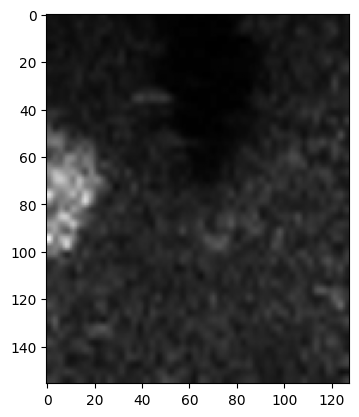

In [25]:
def normalize_for_display(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Apply this before plotting
blur_img_disp = normalize_for_display(blur_img)
plt.imshow(blur_img_disp)

In [38]:
from skimage.metrics import structural_similarity as ssim
from math import log10
from math import sqrt
import numpy as np
    
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
    


the psnr_score is 27.891702101195854


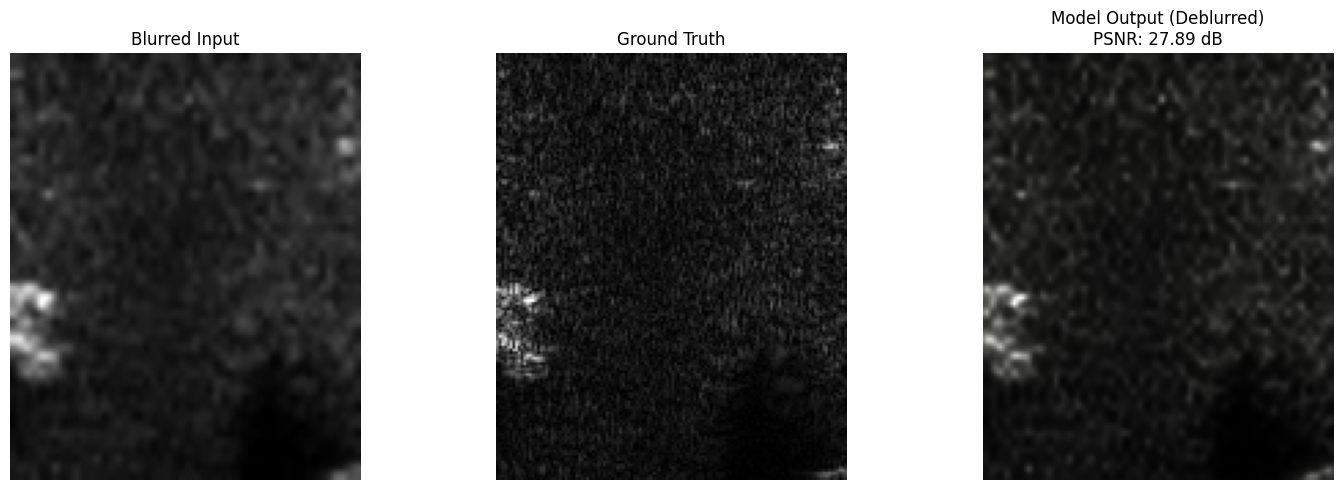


Evaluation loop finished.


In [40]:
# import matplotlib.pyplot as plt
import torch

def prepare_image(tensor_img):
    img = tensor_img.clone().detach()
    img = img.squeeze()  # Remove batch dimension if any
    if img.ndim == 3 and img.shape[0] == 1:  # Grayscale (1, H, W)
        img = img.squeeze(0)
        return img.numpy(), 'gray'
    elif img.ndim == 3 and img.shape[0] == 3:  # RGB (3, H, W)
        img = img.permute(1, 2, 0).numpy()
        return img, None
    elif img.ndim == 2:  # Already (H, W)
        return img.numpy(), 'gray'
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")


# model.eval()
# with torch.no_grad():
#     for blurred_imgs, clean_imgs in test_loader_blur: 
#         blurred_imgs = blurred_imgs.to(device)
#         clean_imgs = clean_imgs.to(device)

        # outputs = model(blurred_imgs)

        # blurred_imgs = blurred_imgs.cpu()
        # clean_imgs = clean_imgs.cpu()
        # outputs = outputs.cpu()
        # for i in range(min(3, len(blurred_imgs))):
        #     blur_img = blurred_imgs[i].permute(1, 2, 0).numpy()
        #     clean_img = clean_imgs[i].permute(1, 2, 0).numpy()
        #     pred_img = outputs[i].permute(1, 2, 0).numpy()
        #     clean_img_np = clean_imgs[0].permute(1, 2, 0).cpu().numpy()
        #     output_img_np = outputs[0].permute(1, 2, 0).detach().cpu().numpy()

        #    # Normalize to [0, 255] range if needed
        #     clean_img_np = (clean_img_np * 255).astype(np.uint8)
        #     output_img_np = (output_img_np * 255).astype(np.uint8)

            # ssim_score = image_comparision(clean_img_np, output_img_np)
            # psnr_score = PSNR(clean_img_np, output_img_np)

            # print("SSIM:", ssim_score)
            # print("PSNR:", psnr_score)

            # blur_img = normalize_for_display(blur_img)
            # clean_img = normalize_for_display(clean_img)
            # pred_img = normalize_for_display(pred_img)

            # plt.figure(figsize=(15, 5))
            # plt.subplot(1, 3, 1)
            # plt.imshow(blur_img)
            # plt.title("Blurred Input")
            # plt.axis('off')

            # plt.subplot(1, 3, 2)
            # plt.imshow(clean_img)
            # plt.title("Ground Truth")
            # plt.axis('off')

            # plt.subplot(1, 3, 3)
            # plt.imshow(pred_img)
            # plt.title("Model Output (Deblurred)")
            # plt.axis('off')

            # plt.tight_layout()
            # plt.show()
            # break

model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    batch_count = 0
    for blurred_imgs, clean_imgs in test_loader_blur:
        blurred_imgs = blurred_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(blurred_imgs)
        blurred_imgs_cpu = blurred_imgs.cpu()
        clean_imgs_cpu = clean_imgs.cpu()
        outputs_cpu = outputs.cpu()
        num_images_to_show = min(1, len(blurred_imgs_cpu))  

        for i in range(num_images_to_show):
            clean_img_metric = (clean_imgs_cpu[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            output_img_metric = (outputs_cpu[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            # Clip output just in case model outputs slightly outside [0, 1]
            output_img_metric = np.clip(output_img_metric, 0, 255)
            psnr_score = PSNR(clean_img_metric, output_img_metric)
            print("the psnr_score is",psnr_score)
            blur_img_display = normalize_for_display(blurred_imgs_cpu[i].permute(1, 2, 0).numpy())
            clean_img_display = normalize_for_display(clean_imgs_cpu[i].permute(1, 2, 0).numpy())
            pred_img_display = normalize_for_display(outputs_cpu[i].permute(1, 2, 0).numpy())

            # --- Plotting ---
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(blur_img_display)
            plt.title("Blurred Input")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(clean_img_display)
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_img_display)
            plt.title(f"Model Output (Deblurred)\nPSNR: {psnr_score:.2f} dB") # Add scores to title
            plt.axis('off')

            plt.tight_layout()
            plt.show()

       
        break 

print("\nEvaluation loop finished.")






In [58]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

for blurred_imgs, clean_imgs in test_loader_blur:
        blurred_imgs = blurred_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(blurred_imgs)
        blurred_imgs_cpu = blurred_imgs.cpu()
        clean_imgs_cpu = clean_imgs.cpu()
        outputs_cpu = outputs.cpu()
    
        clean_img_metric = (clean_imgs_cpu[i].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8)
        output_img_metric = (outputs_cpu[i].permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8)
        output_img_metric = np.clip(output_img_metric, 0, 255)
    
        s=ssim(clean_img_metric,output_img_metric,win_size=3)
        print(s)
        p=peak_signal_noise_ratio(clean_img_metric,output_img_metric)
        print(p)
    
        
    


0.010060379003081333
6.178365516480709
0.007618403502792776
5.915802237342655
0.010780791270901589
6.33257735470221
0.0086291959307839
6.051940170778539
0.008590179672931911
5.8821599279500525
0.00664297356171245
5.656892387796533
0.009208406070050473
5.937295523011138
0.010177530165260745
5.967982549896787
0.011009624097864807
5.81129391317842
0.009790691052502888
6.306791861066356
0.007571360238532096
5.722247723691842
0.008278060275339675
5.729964032205452
0.00910670755710122
6.113051559815052
0.00883586703397006
5.6566836659466935
0.01151942567847774
5.968355156485748
0.008678600970988952
5.967085317126473
0.007601312199809893
5.613437799474719
0.007803391189759139
5.819576900503512
